# CS-7641 Assignment 1

## 1. Data Loading

### Load Necessary Packages

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, ValidationCurveDisplay, LearningCurveDisplay
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, r2_score, mean_absolute_error, mean_squared_error, median_absolute_error, PredictionErrorDisplay
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC, SVR

import itertools
import timeit



### Load Resale Flat Dataset

In [11]:
# If this file reference does not work, please update accordingly.
df_resale = pd.read_csv("./dataset/resale/ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")

# Check if dataset contains missing data
if df_resale.isnull().values.any():
    print("There are missing data in the dataset")

### Load Phishing Websites Dataset

In [3]:
df_phish = pd.read_csv("./dataset/phishing/Phishing_Legitimate_full.csv")

# Check if dataset contains missing data
if df_phish.isnull().values.any():
    print("There are missing data in the dataset")

### Create Helper Functions

In [4]:
def generate_optimal(model_type, clf, X_train, X_test, y_train, y_test):

    # Time training
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time

    # Time prediction
    start_time = timeit.default_timer()
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    prediction_time = end_time - start_time

    if ("Classifier" in model_type or "SVC" in model_type or "kNN" in model_type):
        # Get metrics
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
        disp.plot()
        plt.show()
        print("Results for " + model_type)
        print("Training Time: " + "{:.10f}".format(training_time))
        print("TestingPrediction Time (s): " + "{:.10f}".format(prediction_time))
        print("F1 Score: " + "{:.2f}".format(f1))
        print("Accuracy: " + "{:.2f}".format(accuracy))
        print("AUC: " + "{:.2f}".format(auc))
        print("Precision: " + "{:.2f}".format(precision))
        print("Recall: "  + "{:.2f}".format(recall))
    else:
        r2 = r2_score(y_test, y_pred)
        mean_ae = mean_absolute_error(y_test, y_pred)
        mean_se = mean_squared_error(y_test, y_pred)
        median_ae = median_absolute_error(y_test, y_pred)
        disp = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
        disp.plot()
        plt.show()
        print("Results for " + model_type)
        print("Training Time: " + "{:.10f}".format(training_time))
        print("TestingPrediction Time (s): " + "{:.10f}".format(prediction_time))
        print("r2 Score: " + "{:.2f}".format(r2))
        print("Mean Absolute Error: " + "{:.2f}".format(mean_ae))
        print("Mean Squared Error: " + "{:.2f}".format(mean_se))
        print("Median Absolute Error: " + "{:.2f}".format(median_ae))
        


## 2. Data Preprocessing

### Preprocess Resale Flats Dataset

In [12]:
# get categories
# Convert column type
df_resale['year'] = pd.to_datetime(df_resale['month']).dt.year

# Group lease_commence_date into bins
min_floor_area = min(df_resale['floor_area_sqm'])
max_floor_area = max(df_resale['floor_area_sqm'])
min_lease_commence_date = min(df_resale['lease_commence_date'])
max_lease_commence_date = max(df_resale['lease_commence_date'])
# print("Min floor area: ", min_floor_area)
# print("Max floor area: ", max_floor_area)
# print("Min lease commence date: ", min_lease_commence_date)
# print("Max lease commence date: ", max_lease_commence_date)
floor_area_bins = np.linspace(min_floor_area, max_floor_area, int((max_floor_area - min_floor_area) // 10))
lease_commence_date_bins = np.linspace(min_lease_commence_date, max_lease_commence_date, int((max_lease_commence_date - min_lease_commence_date) // 10))
df_resale['floor_area_bins'] = pd.cut(df_resale['floor_area_sqm'], floor_area_bins).cat.codes
df_resale['lease_commence_date_bins'] = pd.cut(df_resale['lease_commence_date'], lease_commence_date_bins).cat.codes

# Drop columns that we will not be using
df_resale = df_resale.drop(columns=['month', 'block', 'street_name', 'floor_area_sqm', 'lease_commence_date', 'remaining_lease'])

# Use one-hot encoding
resale_one_hot = ['year', 'town', 'flat_type', 'storey_range', 'flat_model', 'floor_area_bins', 'lease_commence_date_bins']
df_resale_hot = df_resale[resale_one_hot]
df_resale_hot = pd.get_dummies(df_resale_hot).astype('category')
df_resale_numerical = df_resale.drop(resale_one_hot, axis=1)
df_resale_final = pd.concat([df_resale_numerical, df_resale_hot],axis=1)
df_resale_final.describe(include='all')
# df_resale_final.plot(subplots=True, layout =(4,4), kind='bar')

df_resale_sample = df_resale_final.sample(1000)

### Preprocess Phishing Dataset

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

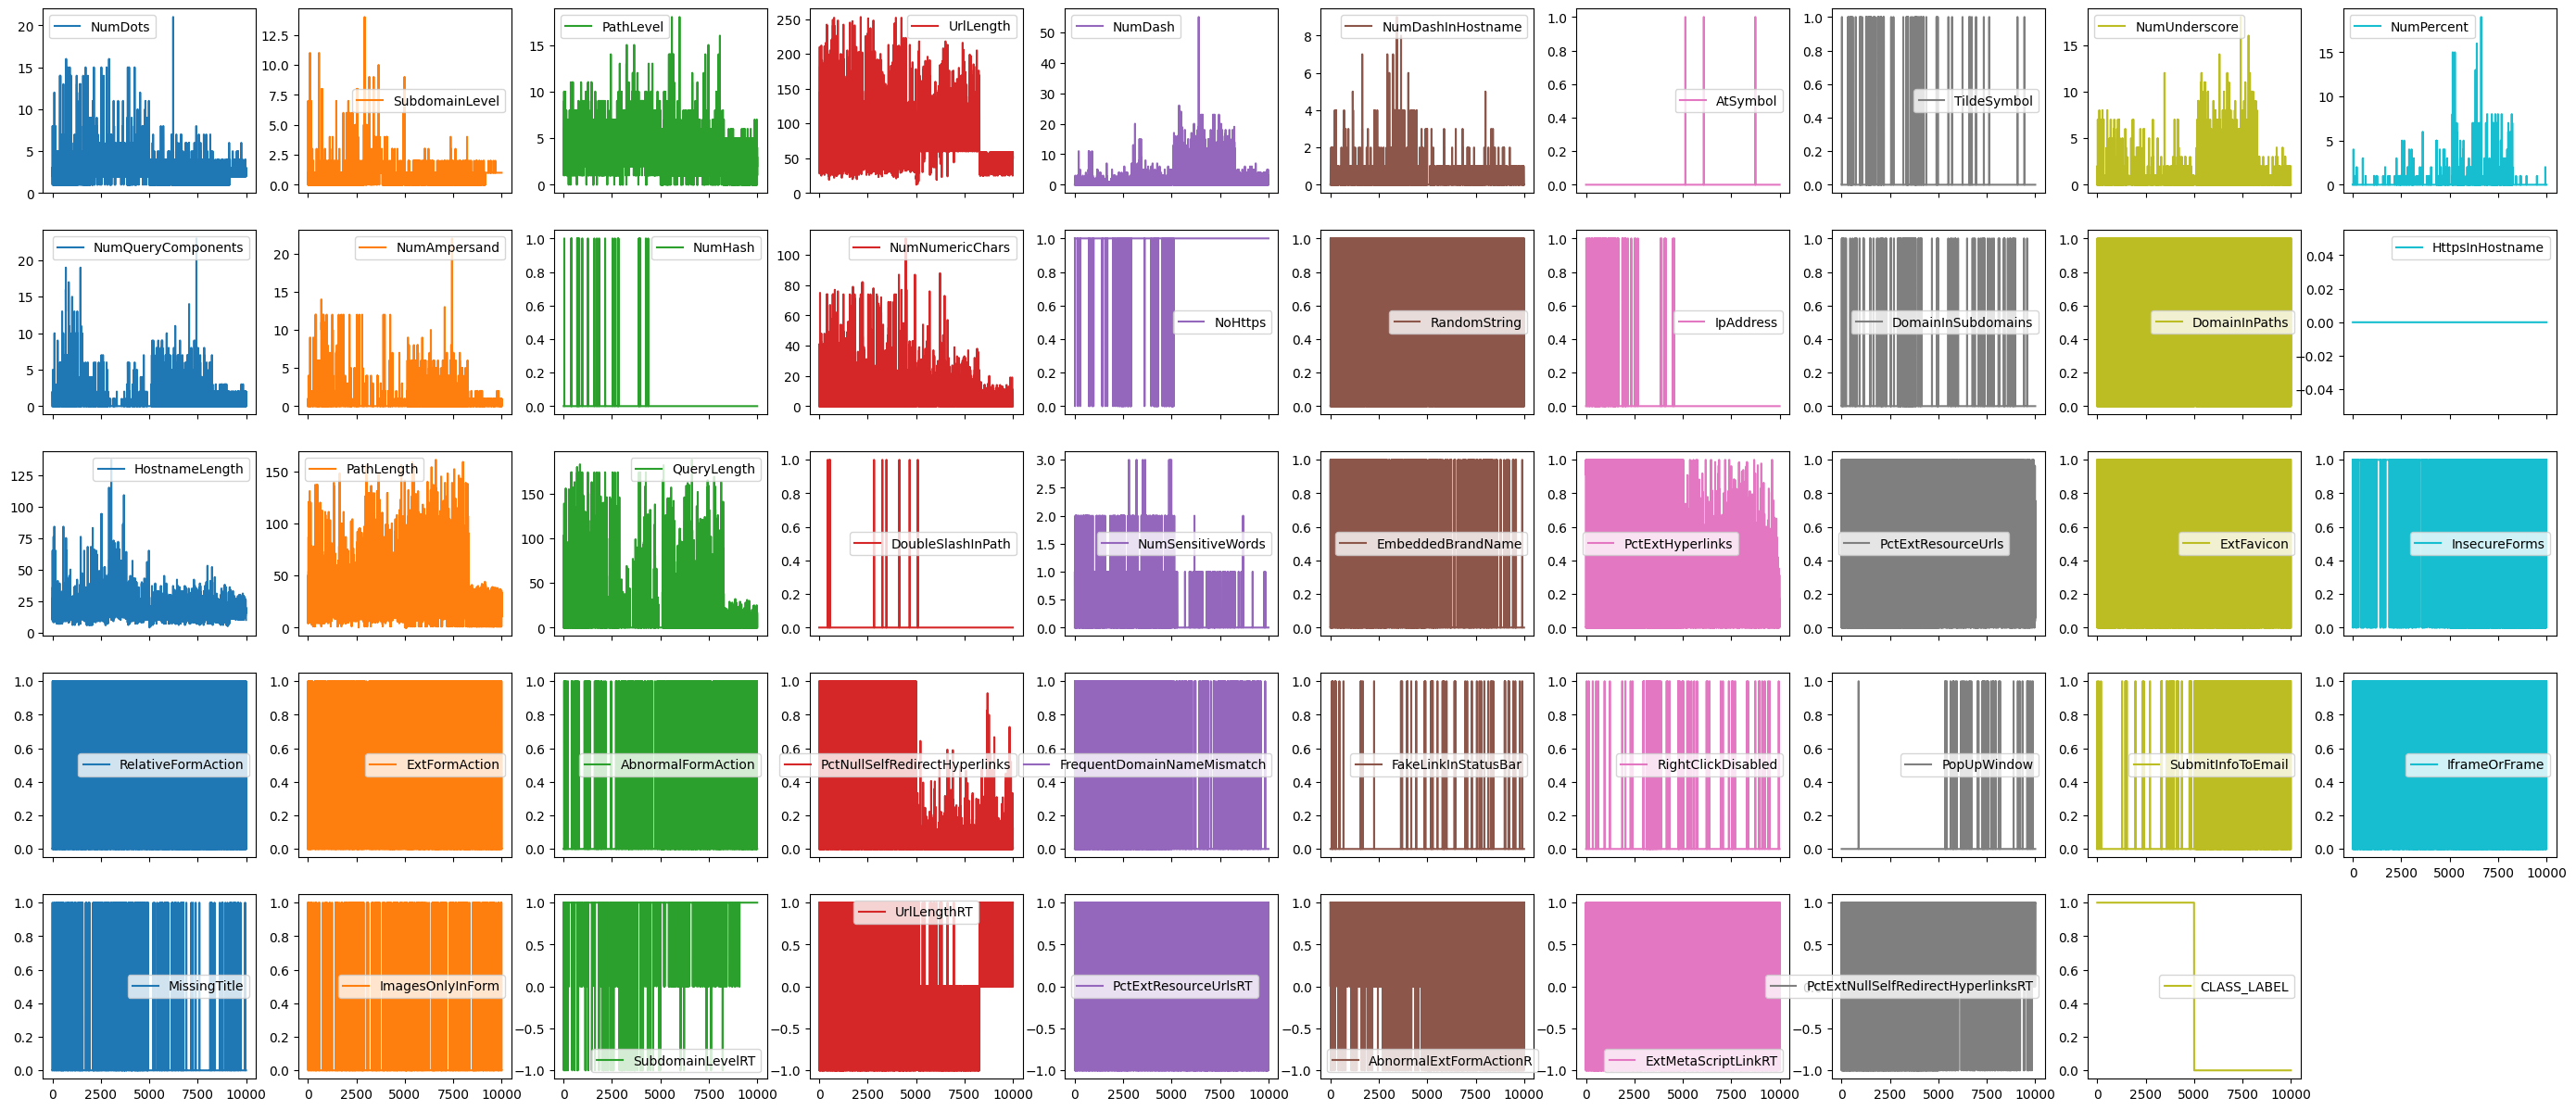

In [6]:
df_phish = df_phish.drop(columns=["id"])
df_phish.plot(subplots=True, layout =(5,10), figsize=(35,15))


## 3. Generate Training and Test Data

We will be splitting up the datasets into training and test data. We will use 20% of each dataset as test data.

### Generate Data for Phishing Dataset

In [8]:
# Generate for Phishing Data
# target column that we want is 'CLASS_LABEL'
df_phish_X = df_phish.drop(["CLASS_LABEL"], axis=1)
df_phish_y = df_phish["CLASS_LABEL"]

phish_X_train, phish_X_test, phish_y_train, phish_y_test = train_test_split(
    np.array(df_phish_X), np.array(df_phish_y), test_size=0.20
)

### Generate Data for Resale Dataset

In [13]:
# Generate for Resale Data
# target column that we want is 'resale_price'
df_resale_x = df_resale_final.drop(['resale_price'], axis=1)
df_resale_y = df_resale_final['resale_price']

resale_X_train, resale_X_test, resale_y_train, resale_y_test = train_test_split(
    np.array(df_resale_x), np.array(df_resale_y), test_size=0.20
)

print('Shape of resale_X_train:', resale_X_train.shape)
print('Shape of resale_X_test:', resale_X_test.shape)
print('Shape of resale_y_train:', resale_y_train.shape)
print('Shape of resale_y_test:', resale_y_test.shape)

# Generate for Resale Data
# target column that we want is 'CLASS_LABEL'
df_resale_sample_x = df_resale_sample.drop(['resale_price'], axis=1)
df_resale_sample_y = df_resale_sample['resale_price']

resale_sample_X_train, resale_sample_X_test, resale_sample_y_train, resale_sample_y_test = train_test_split(
    np.array(df_resale_sample_x), np.array(df_resale_sample_y), test_size=0.20
)

print('Shape of resale_sample_X_train:', resale_sample_X_train.shape)
print('Shape of resale_sample_X_test:', resale_sample_X_test.shape)
print('Shape of resale_sample_y_train:', resale_sample_y_train.shape)
print('Shape of resale_sample_y_test:', resale_sample_y_test.shape)

Shape of resale_X_train: (129470, 74)
Shape of resale_X_test: (32368, 74)
Shape of resale_y_train: (129470,)
Shape of resale_y_test: (32368,)
Shape of resale_sample_X_train: (800, 74)
Shape of resale_sample_X_test: (200, 74)
Shape of resale_sample_y_train: (800,)
Shape of resale_sample_y_test: (200,)


## 4. Modelling

### Decision Trees

#### Phishing Data

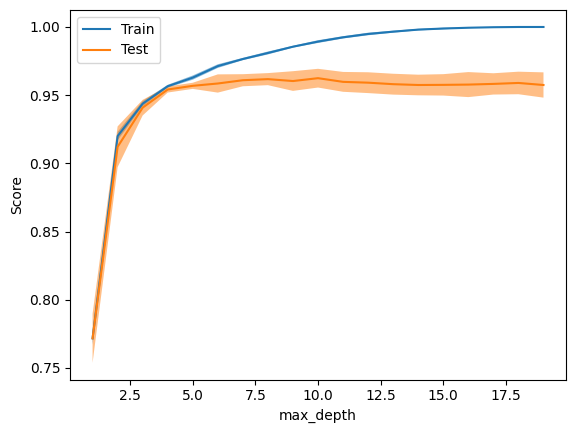

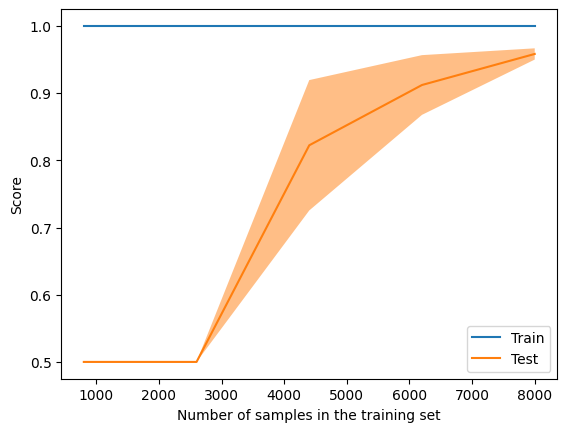

In [75]:


max_depth_list = list(range(1, 20))
ValidationCurveDisplay.from_estimator(
    DecisionTreeClassifier(min_samples_leaf=1, criterion="entropy"),
    np.array(df_phish_X),
    np.array(df_phish_y),
    param_name="max_depth",
    param_range=max_depth_list,
)

# Learning curve
LearningCurveDisplay.from_estimator(
    DecisionTreeClassifier(min_samples_leaf=1, criterion="entropy"),
    np.array(df_phish_X),
    np.array(df_phish_y),
)

In [76]:
# parameters to search:
# min_samples_leaf, max_depth
param_grid = {
    "min_samples_leaf": np.linspace(2, 20, 20).round().astype("int"),
    "max_depth": np.arange(5, 15),
}

tree = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=10)
tree.fit(phish_X_train, phish_y_train)
print("Best params are:")
print(tree.best_params_)
df_phish_tree_result = pd.DataFrame.from_dict(tree.cv_results_)
df_phish_tree_result.loc[tree.best_index_]

Best params are:
{'max_depth': 11, 'min_samples_leaf': 2}


mean_fit_time                                             0.250415
std_fit_time                                              0.076873
mean_score_time                                           0.003802
std_score_time                                            0.001226
param_max_depth                                                 11
param_min_samples_leaf                                           2
params                    {'max_depth': 11, 'min_samples_leaf': 2}
split0_test_score                                          0.97125
split1_test_score                                            0.965
split2_test_score                                           0.9675
split3_test_score                                           0.9675
split4_test_score                                            0.975
split5_test_score                                             0.97
split6_test_score                                            0.975
split7_test_score                                          0.9

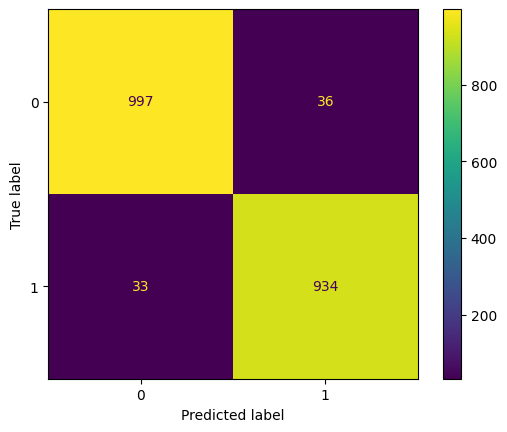

Results for DecisionTreeClassifier
Training Time: 0.1003434000
TestingPrediction Time (s): 0.0014122000
F1 Score: 0.96
Accuracy: 0.97
AUC: 0.97
Precision: 0.96
Recall: 0.97


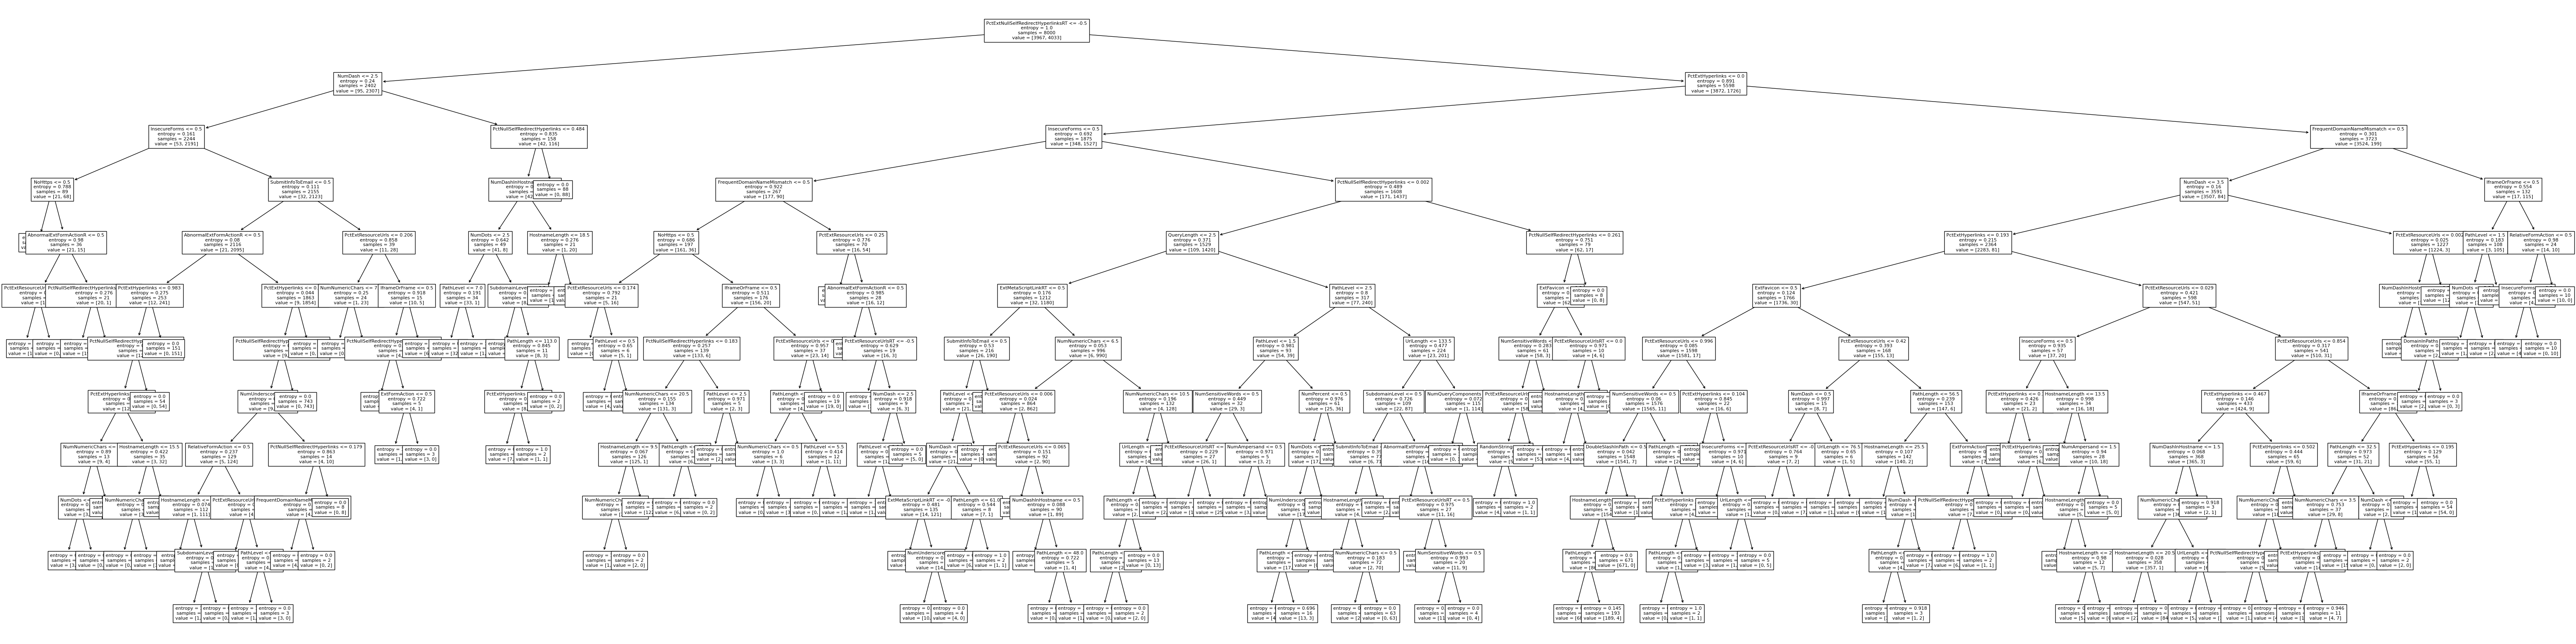

In [77]:
best_clf = DecisionTreeClassifier(
    max_depth=tree.best_params_['max_depth'],
    min_samples_leaf=tree.best_params_['min_samples_leaf'],
    criterion="entropy",
)

generate_optimal("DecisionTreeClassifier", best_clf, phish_X_train, phish_X_test, phish_y_train, phish_y_test)
plt.figure(figsize=(80,20))
plot_tree(best_clf, fontsize=8, feature_names=list(df_phish.columns.values))
plt.show()




#### Resale Data

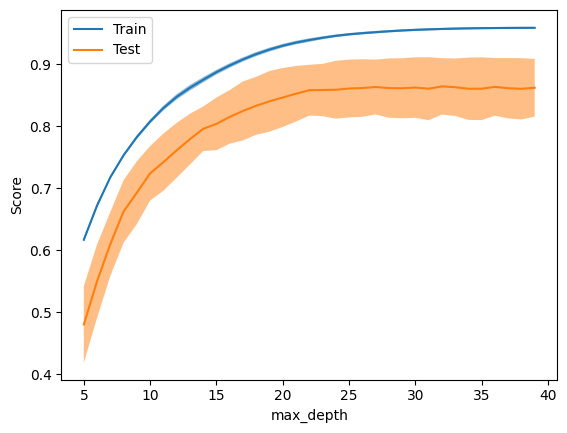

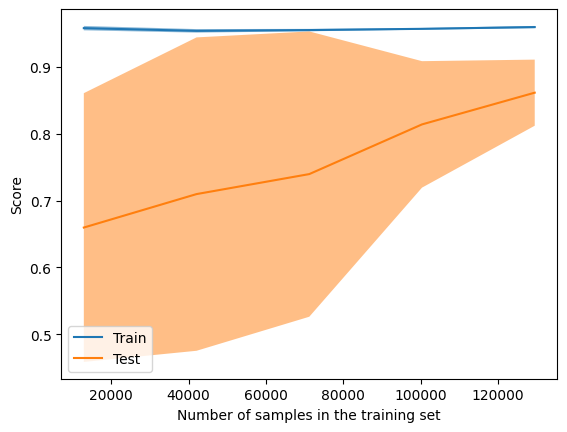

In [78]:

max_depth_list = list(range(5, 40))
ValidationCurveDisplay.from_estimator(
    DecisionTreeRegressor(min_samples_leaf=1, criterion="squared_error"),
    np.array(df_resale_x),
    np.array(df_resale_y),
    param_name="max_depth",
    param_range=max_depth_list,
)

# Learning curve
LearningCurveDisplay.from_estimator(
    DecisionTreeRegressor(min_samples_leaf=1, criterion="squared_error"),
    np.array(df_resale_x),
    np.array(df_resale_y),
)

In [79]:
param_grid = {
    "min_samples_leaf": np.linspace(2, 20, 20).round().astype("int"),
    "max_depth": np.arange(15, 30),
}

tree = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=param_grid, cv=10)
tree.fit(resale_X_test, resale_y_test)
print("Best params are:")
print(tree.best_params_)
df_resale_tree_result = pd.DataFrame.from_dict(tree.cv_results_)
df_resale_tree_result.loc[tree.best_index_]

Best params are:
{'max_depth': 29, 'min_samples_leaf': 3}


mean_fit_time                                             1.008495
std_fit_time                                              0.474318
mean_score_time                                           0.025167
std_score_time                                            0.014365
param_max_depth                                                 29
param_min_samples_leaf                                           3
params                    {'max_depth': 29, 'min_samples_leaf': 3}
split0_test_score                                          0.89631
split1_test_score                                         0.901125
split2_test_score                                         0.903282
split3_test_score                                         0.898477
split4_test_score                                         0.899973
split5_test_score                                         0.902871
split6_test_score                                         0.900134
split7_test_score                                         0.90

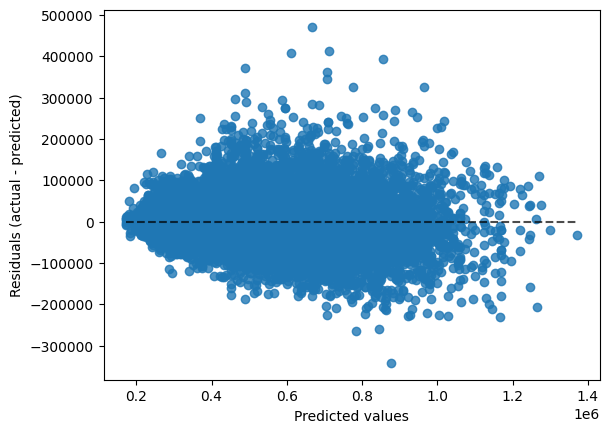

Results for DecisionTreeRegressor
Training Time: 2.5441886000
TestingPrediction Time (s): 0.0978309000
r2 Score: 0.93
Mean Absolute Error: 31344.44
Mean Squared Error: 2011229979.34
Median Absolute Error: 22041.20


In [84]:
best_clf = DecisionTreeRegressor(
    max_depth=tree.best_params_['max_depth'],
    min_samples_leaf=tree.best_params_['min_samples_leaf'],
    criterion="squared_error",
)

generate_optimal("DecisionTreeRegressor", best_clf, resale_X_train, resale_X_test, resale_y_train, resale_y_test)


### Neural Network

#### Phishing Data

c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

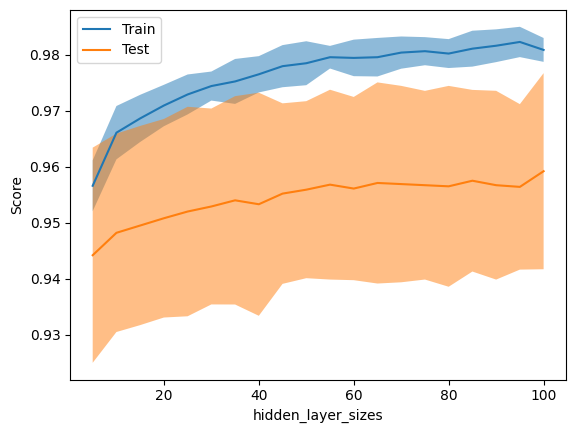

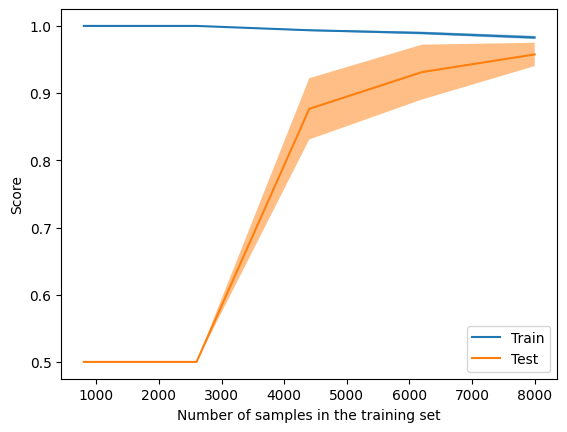

In [85]:
hidden_layer_list = np.linspace(5, 100, 20).astype('int')
ValidationCurveDisplay.from_estimator(
    MLPClassifier(solver='adam', activation='logistic', max_iter=200),
    np.array(df_phish_X),
    np.array(df_phish_y),
    param_name="hidden_layer_sizes",
    param_range=hidden_layer_list,
)

# Learning curve
LearningCurveDisplay.from_estimator(
    MLPClassifier(solver='adam', activation='logistic', max_iter=200),
    np.array(df_phish_X),
    np.array(df_phish_y),
)



In [86]:
h_units = [5, 10, 20, 30, 40, 50, 75, 100]
learning_rates = [0.01, 0.05, 0.1]
param_grid = {"hidden_layer_sizes": h_units, "learning_rate_init": learning_rates}

net = GridSearchCV(
    estimator=MLPClassifier(solver="adam", activation="logistic"),
    param_grid=param_grid,
    cv=10,
)
net.fit(phish_X_train, phish_y_train)
print("Best params are:")
print(net.best_params_)
df_phish_net_result = pd.DataFrame.from_dict(net.cv_results_)
df_phish_net_result.loc[net.best_index_]

Best params are:
{'hidden_layer_sizes': 50, 'learning_rate_init': 0.01}


mean_fit_time                                                         8.39222
std_fit_time                                                          1.12838
mean_score_time                                                       0.00401
std_score_time                                                       0.000768
param_hidden_layer_sizes                                                   50
param_learning_rate_init                                                 0.01
params                      {'hidden_layer_sizes': 50, 'learning_rate_init...
split0_test_score                                                      0.9725
split1_test_score                                                     0.96375
split2_test_score                                                     0.97625
split3_test_score                                                     0.95375
split4_test_score                                                      0.9775
split5_test_score                                               

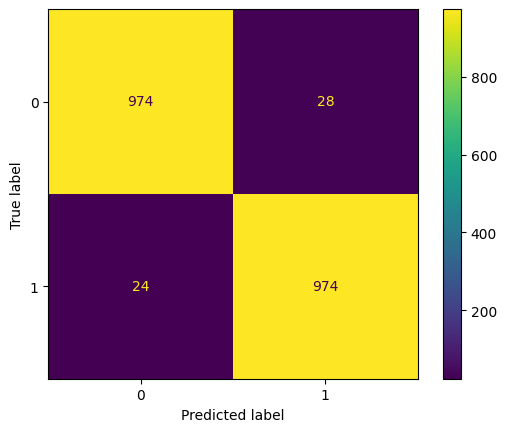

Results for MLPClassifier
Training Time: 65.6125484000
TestingPrediction Time (s): 0.0059891000
F1 Score: 0.97
Accuracy: 0.97
AUC: 0.97
Precision: 0.97
Recall: 0.98


In [18]:
best_net= MLPClassifier(
    solver="adam", activation="logistic", hidden_layer_sizes=net.best_params_['hidden_layer_sizes'], learning_rate_init=net.best_params_['learning_rate_init']
)
generate_optimal("MLPClassifier", best_net, phish_X_train, phish_X_test, phish_y_train, phish_y_test)

#### Resale Data

In [89]:
from sklearn.neural_network import MLPRegressor

hidden_layer_list = np.linspace(20, 100, 20).astype('int')
ValidationCurveDisplay.from_estimator(
    MLPRegressor(solver='adam', activation='logistic', max_iter=200),
    np.array(df_resale_sample_x),
    np.array(df_resale_sample_y),
    param_name="hidden_layer_sizes",
    param_range=hidden_layer_list,
)

# Learning curve
LearningCurveDisplay.from_estimator(
    MLPRegressor(solver='adam', activation='logistic', max_iter=200),
    np.array(df_resale_sample_x),
    np.array(df_resale_sample_y),
)



c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
h_units = [5, 10, 20, 30, 40, 50, 75, 100]
learning_rates = [0.01, 0.05, 0.1]
param_grid = {"hidden_layer_sizes": h_units, "learning_rate_init": learning_rates}

net = GridSearchCV(
    estimator=MLPRegressor(solver="adam", activation="logistic"),
    param_grid=param_grid,
    cv=10,
)
net.fit(resale_sample_X_train, resale_sample_y_train)
print("Best params are:")
print(net.best_params_)
df_resale_net_result = pd.DataFrame.from_dict(net.cv_results_)
df_resale_net_result.loc[net.best_index_]

In [ ]:
best_net = MLPRegressor(
    solver="adam", activation="logistic", hidden_layer_sizes=75, learning_rate_init=0.01
)
generate_optimal("MLPRegressor", best_net, resale_sample_X_train, resale_sample_X_test, resale_sample_y_train, resale_sample_y_test)

### Boosted Decision Tree

#### Phishing Data

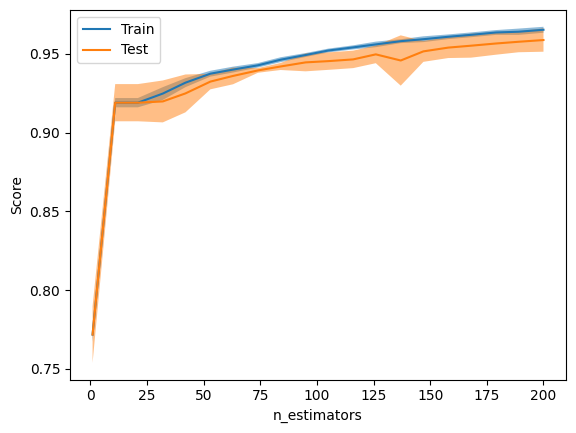

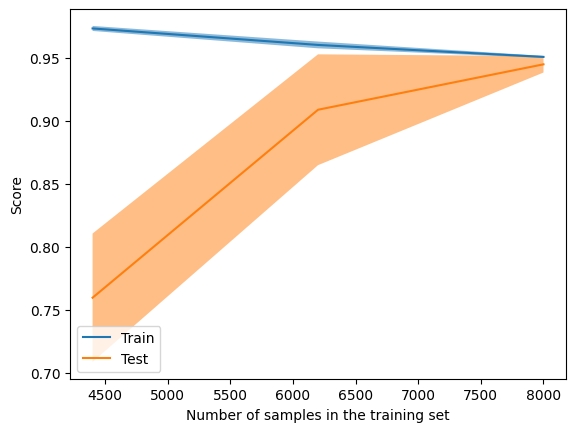

In [19]:
n_estimators_list = np.linspace(1, 200, 20).astype("int")
ValidationCurveDisplay.from_estimator(
    GradientBoostingClassifier(learning_rate=0.1, max_depth=1, random_state=0),
    np.array(df_phish_X),
    np.array(df_phish_y),
    param_name="n_estimators",
    param_range=n_estimators_list,
)

# Learning curve
LearningCurveDisplay.from_estimator(
    GradientBoostingClassifier(learning_rate=0.1, max_depth=1, random_state=0),
    np.array(df_phish_X),
    np.array(df_phish_y),
)

In [20]:
param_grid = {
    "min_samples_leaf": np.linspace(round(0.005*len(phish_X_train)), round(0.05*len(phish_X_train)), 3)
    .round()
    .astype("int"),
    "max_depth": np.arange(1, 4),
    "n_estimators": np.linspace(10, 100, 3).round().astype("int"),
    "learning_rate": np.linspace(0.001, 0.1, 3),
}

boost = GridSearchCV(
    estimator=GradientBoostingClassifier(), param_grid=param_grid, cv=10
)
boost.fit(phish_X_train, phish_y_train)
print("Best params are:")
print(boost.best_params_)
df_phish_boost_result = pd.DataFrame.from_dict(boost.cv_results_)
df_phish_boost_result.loc[boost.best_index_]

Best params are:
{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 40, 'n_estimators': 100}


mean_fit_time                                                       1.88102
std_fit_time                                                       0.026479
mean_score_time                                                     0.00232
std_score_time                                                     0.000336
param_learning_rate                                                     0.1
param_max_depth                                                           3
param_min_samples_leaf                                                   40
param_n_estimators                                                      100
params                    {'learning_rate': 0.1, 'max_depth': 3, 'min_sa...
split0_test_score                                                     0.975
split1_test_score                                                    0.9725
split2_test_score                                                   0.97625
split3_test_score                                                   0.97375
split4_test_

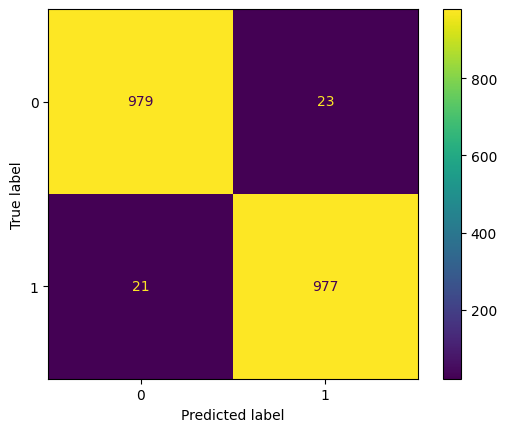

Results for GradientBoostingClassifier
Training Time: 2.0971404000
TestingPrediction Time (s): 0.0038729000
F1 Score: 0.98
Accuracy: 0.98
AUC: 0.98
Precision: 0.98
Recall: 0.98


In [22]:
best_clf = GradientBoostingClassifier(
    learning_rate=boost.best_params_["learning_rate"],
    max_depth=boost.best_params_["max_depth"],
    min_samples_leaf=boost.best_params_["min_samples_leaf"],
    n_estimators=boost.best_params_["n_estimators"],
)
generate_optimal(
    "GradientBoostingClassifier",
    best_clf,
    phish_X_train,
    phish_X_test,
    phish_y_train,
    phish_y_test,
)

#### Resale Data

In [ ]:
n_estimators_list = np.linspace(1, 200, 50).astype("int")
ValidationCurveDisplay.from_estimator(
    GradientBoostingRegressor(),
    np.array(df_resale_x),
    np.array(df_resale_y),
    param_name="n_estimators",
    param_range=n_estimators_list,
)

# Learning curve
LearningCurveDisplay.from_estimator(
    GradientBoostingRegressor(),
    np.array(df_resale_x),
    np.array(df_resale_y),
)

In [ ]:
param_grid = {
    "min_samples_leaf": np.linspace(round(0.005*len(resale_X_train)), round(0.05*len(resale_X_train)), 3)
    .round()
    .astype("int"),
    "max_depth": np.arange(1, 4),
    "n_estimators": np.linspace(10, 100, 3).round().astype("int"),
    "learning_rate": np.linspace(0.001, 0.1, 3),
}

boost = GridSearchCV(
    estimator=GradientBoostingRegressor(), param_grid=param_grid, cv=10
)
boost.fit(resale_X_train, resale_y_train)
print("Best params are:")
print(boost.best_params_)
df_resale_boost_result = pd.DataFrame.from_dict(boost.cv_results_)
df_resale_boost_result.loc[boost.best_index_]

In [ ]:
best_clf = GradientBoostingRegressor(
    learning_rate=boost.best_params_["learning_rate"],
    max_depth=boost.best_params_["max_depth"],
    min_samples_leaf=boost.best_params_["min_samples_leaf"],
    n_estimators=boost.best_params_["n_estimators"],
)
generate_optimal(
    "GradientBoostingRegressor",
    best_clf,
    resale_X_train,
    resale_X_test,
    resale_y_train,
    resale_y_test,
)

### Support Vector Machines

#### Phishing Data

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U7'), dtype('<U7')) -> None

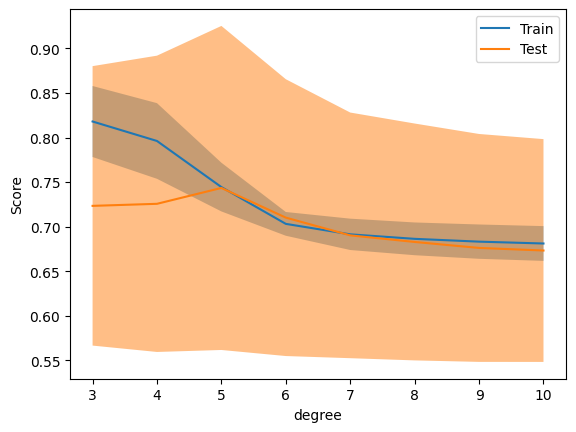

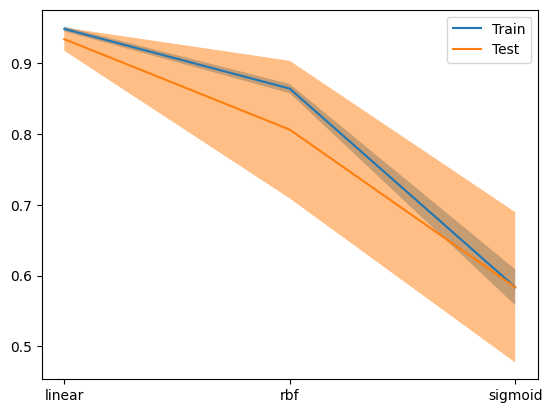

In [24]:
ploy_degree = [3, 4, 5, 6, 7, 8, 9, 10]
ValidationCurveDisplay.from_estimator(
    SVC(kernel='poly'),
    np.array(df_phish_X),
    np.array(df_phish_y),
    param_name="degree",
    param_range=ploy_degree,
)

kernal_list = ['linear', 'rbf', 'sigmoid']
ValidationCurveDisplay.from_estimator(
    SVC(),
    np.array(df_phish_X),
    np.array(df_phish_y),
    param_name="kernel",
    param_range=kernal_list,
)

# Learning curve
LearningCurveDisplay.from_estimator(
    SVC(),
    np.array(df_phish_X),
    np.array(df_phish_y),
)


In [25]:
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10]
}
clf = GridSearchCV(
estimator=SVC(kernel="linear"), param_grid=param_grid, cv=10
)
clf.fit(phish_X_train, phish_y_train)

print("Best params are:")
print(clf.best_params_)
df_phish_SVC_result = pd.DataFrame.from_dict(clf.cv_results_)
df_phish_SVC_result.loc[clf.best_index_]

Best params are:
{'C': 10}


mean_fit_time        90.759318
std_fit_time         16.963216
mean_score_time       0.026396
std_score_time        0.014197
param_C                     10
params               {'C': 10}
split0_test_score       0.9425
split1_test_score      0.93125
split2_test_score      0.94625
split3_test_score      0.94875
split4_test_score       0.9575
split5_test_score      0.95875
split6_test_score      0.95375
split7_test_score      0.92375
split8_test_score      0.95625
split9_test_score      0.95125
mean_test_score          0.947
std_test_score           0.011
rank_test_score              1
Name: 4, dtype: object

In [ ]:
best_clf = SVC(kernel="linear", C=10)
generate_optimal("SVC", best_clf, phish_X_train, phish_X_test, phish_y_train, phish_y_test)

#### Resale Data

In [ ]:
ploy_degree = [2, 3, 4, 5, 6, 7, 8, 9, 10]
ValidationCurveDisplay.from_estimator(
    SVR(kernel="poly"),
    np.array(df_resale_sample_x),
    np.array(df_resale_sample_y),
    param_name="degree",
    param_range=ploy_degree,
)

kernal_list = ["linear", "rbf", "sigmoid"]
ValidationCurveDisplay.from_estimator(
    SVR(),
    np.array(df_resale_sample_x),
    np.array(df_resale_sample_y),
    param_name="kernel",
    param_range=kernal_list,
)

# Learning curve
LearningCurveDisplay.from_estimator(
    SVR(),
    np.array(df_resale_sample_x),
    np.array(df_resale_sample_y),
)

In [ ]:
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10]
}
clf = GridSearchCV(
estimator=SVR(kernel="linear"), param_grid=param_grid, cv=10
)
clf.fit(resale_X_train, resale_y_train)

print("Best params are:")
print(clf.best_params_)
df_resale_SVR_result = pd.DataFrame.from_dict(clf.cv_results_)
df_resale_SVR_result.loc[clf.best_index_]

In [ ]:
best_clf = SVC(kernel="linear", C=10)
generate_optimal("SVC", best_clf, resale_X_train, resale_X_test, resale_y_train, resale_y_train)

### k-Nearest Neighbours

#### Phishing Data

In [ ]:
neighbours_list = np.linspace(1,250,25).astype('int')
ValidationCurveDisplay.from_estimator(
    kNN(n_jobs=-1),
    np.array(df_phish_X),
    np.array(df_phish_y),
    param_name="n_neighbors",
    param_range=neighbours_list,
)

# Learning curve
LearningCurveDisplay.from_estimator(
    kNN(n_jobs=-1),
    np.array(df_phish_X),
    np.array(df_phish_y),
)

In [ ]:
param_grid = {
    "n_neighbors": np.linspace(1,100,25).astype('int')
}
clf = GridSearchCV(
estimator=kNN(n_jobs=-1), param_grid=param_grid, cv=10
)
clf.fit(phish_X_train, phish_y_train)

print("Best params are:")
print(clf.best_params_)
df_phish_kNN_result = pd.DataFrame.from_dict(clf.cv_results_)
df_phish_kNN_result.loc[clf.best_index_]

In [ ]:
best_clf = kNN(n_jobs=-1, n_neighbors=clf.best_params_['n_neighbors'])
generate_optimal("kNN", best_clf, phish_X_train, phish_X_test, phish_y_train, phish_y_test)

#### Resale Data

In [ ]:
neighbours_list = np.linspace(1,250,25).astype('int')
ValidationCurveDisplay.from_estimator(
    KNeighborsRegressor(n_jobs=-1),
    np.array(df_resale_x),
    np.array(df_resale_y),
    param_name="n_neighbors",
    param_range=neighbours_list,
)

# Learning curve
LearningCurveDisplay.from_estimator(
    KNeighborsRegressor(n_jobs=-1),
    np.array(df_resale_x),
    np.array(df_resale_y),
)

In [ ]:
param_grid = {
    "n_neighbors": np.linspace(1,100,25).astype('int')
}
clf = GridSearchCV(
estimator=KNeighborsRegressor(n_jobs=-1), param_grid=param_grid, cv=10
)
clf.fit(resale_X_train, resale_y_train)

print("Best params are:")
print(clf.best_params_)
df_resale_kNN_result = pd.DataFrame.from_dict(clf.cv_results_)
df_resale_kNN_result.loc[clf.best_index_]

In [ ]:
best_clf = KNeighborsRegressor(n_jobs=-1, n_neighbors=clf.best_params_['n_neighbors'])
generate_optimal("KNeighborsRegressor", best_clf, resale_X_train, resale_X_test, resale_y_train, resale_y_test)